<center> <h1> <b>Song Birds<b></h1> </center>
<center> <h2>Model Automatization and Code Update</h2> </center>

# Import Libraries and Functions

In [1]:
from functions import *

In [2]:
from numpy.polynomial import Polynomial

# Classes Definition

In [3]:
class Sillable:    
    def __init__(self, silaba, fs, t0, window_time):
        self.t0 = t0
        self.s  = silaba
        self.fs = fs
        
        self.NN      = 256 
        self.sigma   = self.NN/10
        self.overlap = 1/1.1
        
        self.window_time = window_time#0.005#0.01
        
        sil_filtered = butter_lowpass_filter(self.s, self.fs, lcutoff=15000.0, order=6)
        self.s = butter_highpass_filter(sil_filtered, self.fs, hcutoff=2000.0, order=5)
        
        #self.s = self.s[:floor(np.shape(self.fs)[0]/10)]
        fu_sil, tu_sil, Sxx_sil = get_spectrogram(self.s, self.fs, window=self.NN, overlap=self.overlap, sigma=self.sigma) #espectro silaba
        
        self.envelope = normalizar(envelope_cabeza(self.s,intervalLength=0.01*np.size(self.s)), minout=0)
        self.time     = np.linspace(0, len(self.s)/self.fs, len(self.s))
        self.fu       = fu_sil
        self.tu       = tu_sil-tu_sil[0]#+self.t0-self.window_time/2#+self.t0-self.window_time/2
        self.Sxx      = Sxx_sil
        self.T        = self.tu[-1]-self.tu[0]
        
        self.fs_new   = int(self.T*self.fs)   # number of points for the silabale/chunck

        #self.time     = np.linspace(0, len(self.s)/self.fs, len(self.s))#np.linspace(0, self.T*len(self.s)/self.fs, len(self.s))
        
        self.window_length = 0.008
    
        SCI, time_ampl, freq_amp, Ampl_freq, freq_amp_int , time_inter = FFandSCI(self.s, self.time, self.fs, self.t0, len(self.s), window_time=self.window_time)
        
        
        self.time_ampl          = time_ampl-time_ampl[0]
        self.time_inter         = time_inter-time_inter[0]
        self.Ampl_freq_filtered = Ampl_freq #_filtered
        self.freq_amp_smooth    = freq_amp_int#_smooth           # satisfies fs
        self.freq_amp           = freq_amp                         # less values than smooth
        self.SCI                = SCI
        self.time               = np.linspace(0, self.tu[-1], len(self.s))
    
    def AlphaBeta(self, param): # alpha = a0+a1*t+a2*t^2, beta = b0+b1*t+b2*t^2,
        #self.parametros = param
        self.gamma = param['gamma']
        a          = np.array([param['a0'], param['a1'], param['a2']]);   
        b          = np.array([param['b0'], param['b1'], param['b2']])
        
        t_1   = np.linspace(0,self.T,len(self.s))#np.shape(copeton.silaba.time_inter)[0])
        t_par = np.array([1*np.ones(len(self.s)), t_1, t_1**2])

        # approx alpha and beta as polynomials
        self.alpha = np.dot(a, t_par);   # self.beta = np.dot(b, t_par)
        #self.beta = 1e-4*self.freq_amp_smooth + b[0]
        poly = Polynomial.fit(self.time_inter, self.freq_amp_smooth, deg=10)
        x,y = poly.linspace(np.size(self.s))
        self.beta = 1e-4*y + b[0]
        
    
    def BirdModel(self, sampling=44100, oversamp=20):
        N_total = len(self.s)

        #sampling and necessary constants
        sampling, oversamp = sampling, oversamp
        out_size  = int(N_total)
        dt        = 1./(oversamp*sampling)
        tmax      = out_size*oversamp

        # vectors initialization
        out = np.zeros(out_size)
        a   = np.zeros(tmax)
        db  = np.zeros(tmax)

        # counters 
        n_out, tcount = 0, 0
        taux, tiempot = 0, 0

        forcing1, forcing2, A1 = 0., 0., 0
        
        v = 1e-12*np.array([5, 10, 1, 10, 1])
        #'''
        BirdDataOff          = pd.read_csv(auxdata_path+'BirdData_Copeton_off.csv')
        BirdDataOn           = pd.read_csv(auxdata_path+'BirdData_Copeton_on.csv')
        BirdDataOff['value'] = BirdDataOff['value'].apply(lambda x: eval(x))
        BirdDataOn['value']  = BirdDataOn['value'].apply(lambda x: eval(x))
                
        c, ancho, largo, s1overCH, s1overLB, s1overLG, RB, r, rdis = BirdDataOff['value']
        
        t = tau = int(largo/(c*dt + 0.0))
        
        #def dxdt_synth_bird(v, dv, alfa1, beta1, gm, s1overLG, s1overCH, rdis, s1overLB, forcing1, forcing2, RB):
        def dxdt_synth(v):
            x, y, i1, i2, i3 = v #x, y, i1, i2, i3 = v[0], v[1], v[2], v[3], v[4]
            dv    = np.zeros(5)
            dv[0] = y
            dv[1] = - alfa1*gm**2 - beta1*gm**2*x - gm**2*x**3 - gm*x**2*y + gm**2*x**2 - gm*x*y
            dv[2] = i2
            dv[3] = -s1overLG*s1overCH*i1 - rdis*(s1overLB+s1overLG)*i2 \
                + i3*(s1overLG*s1overCH-rdis*RB*s1overLG*s1overLB) \
                + s1overLG*forcing2 + rdis*s1overLG*s1overLB*forcing1
            dv[4] = -(s1overLB/s1overLG)*i2 - RB*s1overLB*i3 + s1overLB*forcing1
            return dv

        gm       = self.gamma
        alfa1    = self.alpha[0] 
        beta1    = self.beta[0]
        amplitud = self.envelope[0]

        while t < tmax and v[1] > -5000000:
            # -------- trachea ---------------
            dbold  = db[t]                              # forcing 1, before
            a[t]   = (.50)*(1.01*A1*v[1]) + db[t-tau]   # a = Pin, pressure:v(t)y(t) + Pin(t-tau) # envelope*
            db[t]  = -r*a[t-tau]                        # forcing 1, after: -rPin(t-tau)
            ddb    = (db[t]-dbold)/dt                   # Derivada, dPout/dt=Delta forcing1/dt

            forcing1, forcing2, PRESSURE = db[t], ddb, a[t] #  -rPin(t-tau),  dPout/dt,   v(t)y(t) + Pin(t-tau)

            tiempot += dt
            v = rk4(dxdt_synth, v, dt)

            preout = RB*v[4]
            s1overCH, s1overLB, s1overLG, RB, r, rdis = BirdDataOn['value'][3:]

            noise    = 0.21*(uniform(0, 1) - 0.5)
            beta1   += 0.0*noise
            A1       = amplitud + 0.0*noise

            if taux == oversamp and n_out<self.fs-1:
                out[n_out]   = preout*10
                n_out       += 1

                beta1, alfa1 = self.beta[n_out], self.alpha[n_out]
                amplitud     = self.envelope[n_out]
                taux         = 0
                #if (n_out*100/N_total) % 5 == 0:  print('{:.0f}%'.format(100*n_out/N_total)) # dp = 5 (() % dp == 0)
                
            t += 1;   taux += 1;
        #print('100%')

        # pre processing synthetic data
        self.synth_env         = normalizar(envelope_cabeza(out, intervalLength=0.01*np.size(self.s)), minout=0)
        self.out_amp           = np.zeros_like(out)
        not_zero               = np.where(self.synth_env > 0.005)
        self.out_amp[not_zero] = out[not_zero] * self.envelope[not_zero] / self.synth_env[not_zero]
        self.s_amp_env         = normalizar(envelope_cabeza(self.out_amp, intervalLength=0.01*np.size(self.s)), minout=0)
        #self.out = out
        
        #print(self.out_amp)
        fu_s, tu_s, Sxx_s = get_spectrogram(self.out_amp, self.fs, window=self.NN,  overlap=self.overlap, sigma=self.sigma)  # out normalized
        
        self.tu_out   = tu_s-tu_s[0]#-self.window_time/2 # -self.t0
        self.fu_out   = fu_s
        self.Sxx_out  = Sxx_s
        self.time_out = np.linspace(0, len(self.out_amp)/self.fs, len(self.out_amp))
        
        #print(self.out_amp)
        
        SCI, time_ampl, freq_amp, Ampl_freq, freq_amp_int , time_inter = FFandSCI(self.out_amp, self.time, self.fs, self.t0, len(self.s), method="song", window_time=self.window_time) #FFandSCI(self.out_amp, self.tu_out, fs=self.fs,window_length=self.window_length, method='song')
        
        #
        self.time_ampl_out          = time_ampl
        self.time_inter_out         = time_inter-time_inter[0]
        self.Ampl_freq_filtered_out = Ampl_freq#Ampl_freq_filtered
        self.freq_amp_smooth_out    = freq_amp_int           # satisfies fs
        self.freq_amp_out           = freq_amp                         # less values than smooth
        self.SCI_out                = SCI
        self.time_out = np.linspace(0, self.tu_out[-1], len(self.out_amp)) #-self.t0
    
    def Audio(self):
        wavfile.write('{}/synth4_amp_{}_{}.wav'.format(examples_path,num_file,no_silaba), self.fs, np.asarray(normalizar(self.out_amp),  dtype=np.float32))
        wavfile.write('{}/song_{}_{}.wav'.format(examples_path,num_file,no_silaba),       self.fs, np.asarray(normalizar(self.s),        dtype=np.float32))
    
    ## ----------------------- PLOT FUNCTIONS --------------------------
    def PlotSynth(self):
        
        fig, ax = plt.subplots(2, 2, figsize=(12, 5), sharex=True, sharey='col')
        fig.subplots_adjust(top=0.85)     
        
        ax[0][0].plot(self.time, normalizar(self.s), label='canto')
        ax[0][0].set_title('Real')
        ax[0][0].plot(self.time, self.envelope, label='envelope')
        ax[0][0].legend(); ax[0][0].set_ylabel("Amplitud (a.u.)")

        ax[1][0].plot(self.time_out, normalizar(self.out_amp), label='normalized output')
        ax[1][0].set_title('Synthetic') 
        ax[1][0].plot(self.time_out, self.s_amp_env, label='envelope')
        ax[1][0].legend(); ax[1][0].set_xlabel('t (s)'); ax[1][0].set_ylabel("Amplitud (a.u.)")

        Delta_tu   = self.tu[-1] - self.tu[0]
        Delta_tu_s = 1#tu_s[-1] - tu_s[0]

        ax[0][1].pcolormesh(self.tu, self.fu*1e-3, np.log(self.Sxx), cmap=plt.get_cmap('Greys'), rasterized=True)
        ax[0][1].plot(self.time_inter, self.freq_amp_smooth*1e-3, 'b-', label='Smoothed and Interpolated\nto {0} fs'.format(self.fs), lw=2)
        ax[0][1].set_title('Real'); ax[0][1].set_ylabel('f (khz)'); ax[0][1].set_ylim(0, 10);

        ax[1][1].pcolormesh(self.tu_out, self.fu_out*1e-3, np.log(self.Sxx_out), cmap=plt.get_cmap('Greys'), rasterized=True, label='output normalizado amplitud')
        ax[1][1].plot(self.time_inter, self.freq_amp_smooth_out*1e-3, 'b-', label='Smoothed and Interpolated\nto {0} fs'.format(self.fs), lw=2)
        ax[1][1].set_title('Synthetic') 
        ax[1][1].set_ylim(0, 10);   ax[1][1].set_xlim(min(self.time_out), max(self.time_out))
        ax[1][1].set_xlabel('t (s)'); ax[1][1].set_ylabel('f (khz)');

        #fig.tight_layout(); 
        fig.suptitle('Sound Waves and Spectrograms', fontsize=20)#, family='fantasy');
        
    def PlotAlphaBeta(self, xlim=(-0.05,.2), ylim=(-0.2,0.9)):
        fig = plt.figure(constrained_layout=True, figsize=(10, 6))
        gs  = GridSpec(2, 2, figure=fig)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[1:, 0])
        ax3 = fig.add_subplot(gs[:, 1])

        fig.suptitle("GridSpec")
        fig.tight_layout(pad=3.0)        #fig.subplots_adjust(top=0.85)
        
        viridis = cm.get_cmap('Blues')
        c       = viridis(np.linspace(0.3, 1, np.size(self.time_inter)))
        
        ax1.scatter(self.time_inter, self.alpha, c=c, label="alfa")
        ax1.set_title('Air-sac Pressure')
        ax1.grid()
        ax1.set_ylabel('α (a.u.)'); #ax1.set_xlabel('Time (s)'); 
        ax1.set_ylim(xlim);        #ax[0].legend()

        ax2.scatter(self.time_inter, self.beta, c=c, label="beta")
        ax2.set_title('Labial Tension')
        ax2.grid()
        ax2.set_xlabel(r'Time (s)'); ax2.set_ylabel('β (a.u.)')
        ax2.set_ylim(ylim);         ax2.sharex(ax1);        #ax[0].legend()

        # ------------- Bogdanov–Takens bifurcation ------------------
        mu2 = np.linspace(-2.5, 1/3, 1000)
        xmas = (1+np.sqrt(1-3*mu2))/3
        xmen = (1-np.sqrt(1-3*mu2))/3
        mu1_mas = -mu2*xmas - xmas**3 + xmas**2
        mu1_men = -mu2*xmen - xmen**3 + xmen**2
        #---------------------------------------------------------------

        ax3.scatter(self.alpha, self.beta, c=c, label="Parameters", marker="_")
        ax3.plot(-1/27, 1/3, 'ko', label="Cuspid Point"); 
        ax3.axvline(0, color='red', lw=1, label="Hopf Bifurcation")
        ax3.plot(mu1_men, mu2, '-g', lw=1, label="Saddle-Noddle\nBifurcation"); 
        ax3.plot(mu1_mas, mu2, '-g', lw=1)
        ax3.fill_between(mu1_mas, mu2, 10, where=mu1_mas > 0, color='gray', alpha=0.25, label='BirdSongs')
        ax3.set_ylabel('Tension (a.u.)'); ax3.set_xlabel('Pressure (a.u.)')
        ax3.set_title('Parameter Space')
        ax3.legend()
        ax3.set_xlim(xlim); ax3.set_ylim(ylim)
        fig.suptitle("Air-sac Pressure (α) and Labial Tension (β) Parameters", fontsize=20)#, family='fantasy')

    def Plot(self, flag=0):
        fig, ax = plt.subplots(2, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [3, 2]},sharex=True)
        fig.subplots_adjust(top=0.85);   #fig.tight_layout(pad=3.0)
        
        ax[0][0].pcolormesh(self.tu, self.fu*1e-3, np.log(self.Sxx), cmap=plt.get_cmap('Greys'), rasterized=True)
        ax[0][0].plot(self.time_inter, self.freq_amp_smooth*1e-3, 'bo', label='Real',ms=10)
        ax[0][0].plot(self.time_inter, self.freq_amp_smooth_out*1e-3, 'gx', label='Synthetic', ms=6)
        ax[0][0].plot(self.time_ampl, self.freq_amp*1e-3, 'r+', label='sampled ff', ms=5)
        ax[0][0].legend()#title="Fundamenta Frequency")
        ax[0][0].set_ylim((1, 10)); ax[0][0].set_xlim((self.tu[0], self.tu[-1]))
        ax[0][0].set_xlabel('time (s)');     ax[0][0].set_ylabel('f (hz)')
        ax[0][0].set_title('Fundamental Frequency (FF)')

        ax[0][1].plot(self.time_ampl, self.SCI, 'o', ms=3, label='mean {0:.2f}'.format(np.mean(self.SCI)))
        ax[0][1].plot(self.time_ampl, self.SCI_out, 'o', ms=3, label='mean {0:.2f}'.format(np.mean(self.SCI_out)))
        if flag: 
            m,  b  = np.polyfit(self.time_ampl, self.SCI, 1)
            mo, bo = np.polyfit(self.time_ampl, self.SCI_out, 1)
            ax[0][1].plot(self.time_ampl, m*self.time_ampl+b, 'b-', label='m={0:.2f}, b={1:.2f} '.format(m,b))
            ax[0][1].plot(self.time_ampl, mo*self.time_ampl+bo, 'r-', label='m={0:.2f}, b={1:.2f} '.format(mo,bo))
        ax[0][1].legend()
        ax[0][1].set_xlabel('time (s)'); ax[0][1].set_ylabel('SCI')
        ax[0][1].set_title('Spectral Content Index (SCI)')
        
        ax[1][0].plot(self.time_inter, self.ScoreFF(), "-o", color="k", label='Σ R(FF)/len(s)= {:.4f}'.format(np.sum(self.ScoreFF())))
        ax[1][0].set_xlabel('time (s)'); ax[1][0].set_ylabel('Error (kHz)'); ax[1][0].legend()
        ax[1][0].set_title('Fundamental Frequency Error (ΔFF)'); ax[1][0].set_ylim((-0.1,10))
        
        ax[1][1].plot(self.time_ampl, self.ScoreSCI(), "-o", color="k", label='Σ R(SCI) = {:.4f}'.format(np.sum(self.ScoreSCI())) )
        ax[1][1].set_xlabel('time (s)'); ax[1][1].set_ylabel('Error (adimensionless)'); ax[1][1].legend()
        ax[1][1].set_title('Spectral Content Index Error (ΔSCI)')
        
        fig.suptitle("Scored Variables", fontsize=20)#, family='fantasy')
    
    ## ---------------- SCORED FUNCTIONS --------------
    def OptFF(self, param):
        self.AlphaBeta(param)
        self.BirdModel()
        return np.sum(self.ScoreFF())/len(self.s)
    
    def OptSCI(self, param):
        self.AlphaBeta(param)
        self.BirdModel()
        return np.sum(self.ScoreSCI())
    
    def ScoreFF(self):  return 1e-3*abs(self.freq_amp_smooth_out - self.freq_amp_smooth)
    def ScoreSCI(self): return abs(self.SCI_out-self.SCI) 
    
    
    def OptimizationFF(self, p, method='brute', **kwargs): #max_nfev=500
        def residualFF(p):  return self.OptFF(p.valuesdict())
        start = time.time()
        mi    = lmfit.minimize(residualFF, p, method=method, nan_policy='omit', **kwargs) #, max_nfev=500) #dual_annealing # , Ns=200
        end   = time.time()
        
        return mi, end-start
    
    def OptimizationSCI(self, p, method='brute', **kwargs): #max_nfev=500
        def residualSCI(p): return self.OptSCI(p.valuesdict())
        start = time.time()
        mi    = lmfit.minimize(residualSCI, p, method=method, nan_policy='omit', **kwargs) #, max_nfev=500) #dual_annealing # , Ns=200
        end   = time.time()
        
        return mi, end-start
    
    
    
class Song(Sillable):
    def __init__(self, file_name):
        fs, s = wavfile.read(file_name)
        if len(np.shape(s))>1 and s.shape[1]==2 :s = (s[:,1]+s[:,0])/2 # two channels to one
        
        self.NN       = 1024 
        self.overlap  = 1/1.1
        self.sigma    = self.NN/10
        self.umbral   = 0.05
        
        fu_all, tu_all, Sxx_all = get_spectrogram(s, fs, window=self.NN, overlap=self.overlap, sigma=self.sigma)
        
        self.fs       = fs
        self.s        = s
        self.envelope = normalizar(envelope_cabeza(self.s,intervalLength=0.01*self.fs), minout=0, method='extremos')
        self.time     = np.linspace(0, len(self.s)/self.fs, len(self.s))
        self.fu       = fu_all
        self.tu       = tu_all
        self.Sxx      = Sxx_all
        self.window_time = 0.005
        
        
        self.silabas = self.Silabas()
        
    def SilabaNo(self, no_silaba):
        self.no_silaba    = no_silaba
        ss                = self.silabas[no_silaba-1]  # silbido in indexes 
        silaba            = self.s[ss[0]:ss[-1]]       # silaba en audio
        self.silb_complet = silaba
        self.time_silaba  = self.time[ss[0]:ss[-1]]# -0.02/2
        self.t0           = self.time[ss[0]]
        self.silaba       =  Sillable(silaba, self.fs, self.t0, self.window_time)
        
    def Chunck(self, no_chunck):
        self.no_chunck     = no_chunck
        chunks_s, chunks_t = Windows(self.silb_complet, self.time_silaba, self.fs, window_time=0.02, overlap=1) # overla=1 not overlap
        self.chunck        = Sillable(chunks_s[no_chunck], self.fs, self.t0, self.window_time)#0.005)
        self.chunck.t0     = chunks_t[no_chunck][0]
        
    def Plot(self, flag=0): #flag = 1 or 0
        fig, ax = plt.subplots(2+flag, 1, figsize=(12, 9))#, sharex=True, gridspec_kw={'width_ratios': [1, 1]})
        fig.subplots_adjust(hspace=0.4)
        
        ax[0].pcolormesh(self.tu, self.fu/1000, np.log(self.Sxx), cmap=plt.get_cmap('Greys'), rasterized=True)
        ax[0].plot(self.silaba.time_inter+self.t0, self.silaba.freq_amp_smooth*1e-3, 'b-', label='FF'.format(self.silaba.fs), lw=2)
        ax[0].plot(self.silaba.time_ampl+self.t0, self.silaba.freq_amp*1e-3, 'r+', label='sampled FF', ms=2)
        for ss in self.silabas:   ax[0].plot([self.time[ss[0]], self.time[ss[-1]]], [0, 0], 'k', lw=5)
        
        ax[0].set_ylim(0, 12.000); ax[0].set_xlim(min(self.time), max(self.time));
        ax[0].set_title("Complete Song Spectrum"); 
        ax[0].set_xlabel('t (s)'); ax[0].set_ylabel('f (kHz)')

        ax[1].plot(self.time, self.s/np.max(self.s),'k', label='audio')
        ax[1].plot(self.time, np.ones(len(self.time))*self.umbral, '--', label='umbral')
        ax[1].plot(self.time, self.envelope, label='envelope')
        ax[1].legend()#loc=1, title='Data')
        ax[1].set_title("Complete Song Sound Wave")
        ax[1].set_xlabel('t (s)'); ax[1].set_ylabel('Amplitud normalaized');
        ax[1].sharex(ax[0])

        if flag==1:
            #ax[2].pcolormesh(self.tu, self.fu, np.log(self.Sxx), cmap=plt.get_cmap('Greys'), rasterized=True)
            ax[0].plot(self.chunck.time_inter+self.chunck.t0, self.chunck.freq_amp_smooth*1e-3, 'g-', label='Chunck', lw=4)
            ax[2].pcolormesh(self.silaba.tu+self.t0, self.silaba.fu*1e-3, np.log(self.silaba.Sxx), cmap=plt.get_cmap('Greys'), rasterized=True) 
            ax[2].plot(self.chunck.time_inter+self.chunck.t0, self.chunck.freq_amp_smooth*1e-3, 'g-', label='Chunck', lw=10)
            ax[2].plot(self.silaba.time_inter+self.t0, self.silaba.freq_amp_smooth*1e-3, 'b-', lw=5, label='Smoothed and Interpolated\nto {0}=fs'.format(self.silaba.fs))
            ax[2].plot(self.silaba.time_ampl+self.t0, self.silaba.freq_amp*1e-3, 'r+', label='sampled FF', ms=3)
            ax[2].set_ylim((2, 11)); 
            ax[2].set_xlim((self.silaba.time_inter[0]-0.001+self.t0, self.silaba.time_inter[-1]+0.001+self.t0));
            ax[2].legend()
            ax[2].set_xlabel('t (s)'); ax[2].set_ylabel('f (khz)')
            ax[2].set_title('Single Chunck Spectrum, No {}'.format(self.no_chunck))
        
        ax[0].legend()
        fig.suptitle('Audio: {}'.format(sound_files[num_file][39:]), fontsize=20)#, family='fantasy')
        print('Number of syllables {}'.format(len(self.silabas)))
        
        
    def Silabas(self):
        supra    = np.where(self.envelope > self.umbral)[0]
        silabas  = consecutive(supra, min_length=100)

        return [ss for ss in silabas if len(ss) > 1024] # elimino silabas cortas

# Defining files paths and importing audios

In [4]:
#birdname      = 'Zonotrichia capensis'  # Nombre del ave
base_path     = "C:\\Users\\sebas\\Documents\\GitHub\\BirdSongs\\" # base_path = '/home/siete/Downloads/audios/'
audios_path   = 'C:\\Users\\sebas\\Documents\\GitHub\\Audios\\'
auxdata_path  = '{}AuxiliarData\\'.format(base_path)
results_path  = '{}Results\\'.format(base_path) 
examples_path = '{}Results\\Examples\\'.format(base_path) 

if not os.path.exists(results_path):    os.makedirs(results_path)
if not os.path.exists(examples_path):    os.makedirs(examples_path)

# %% Cargo datos de sonido. Busca todos los archivos del pajaro.
sound_files    = glob.glob(os.path.join(audios_path, '*wav')) #'*'+birdname+'*wav'    busco una carpeta con todos los sonidos de la misma clase

print("Total number of songs: {}".format(len(sound_files)))

Total number of songs: 91


# Choosing File, Silaba, and Chunck

In [7]:
num_file, no_silaba, no_chunck = 2, 5, 0
copeton = Song(sound_files[num_file])

## Plot Song, Silaba, and Chunck

Number of syllables 6


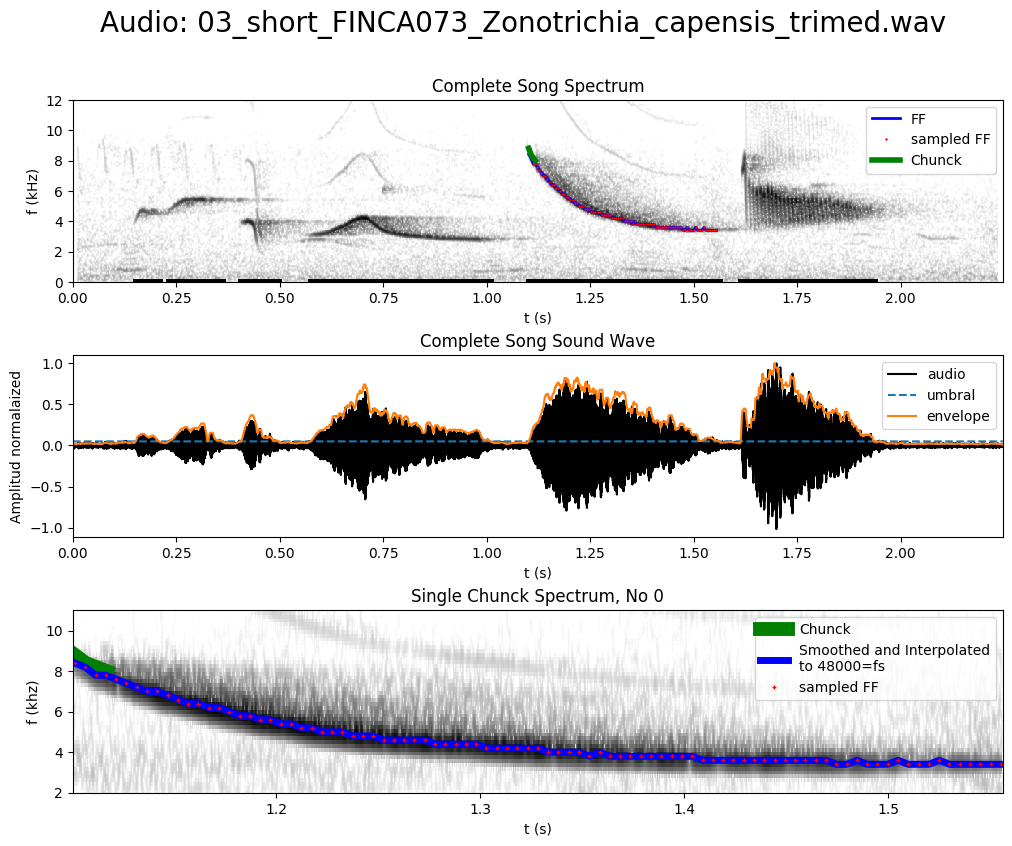

In [8]:
copeton.SilabaNo(no_silaba)
copeton.Chunck(no_chunck)
copeton.Plot(1)

# Chunck i-th 

In [ ]:
parametros = dict([('a0', 0.11),  ('a1', 5e-4),  ('a2', 0), 
                   ('b0', 0.52), ('b1', -1.95), ('b2', 0), ('gamma',20000)])

copeton.chunck.OptSCI(parametros)
copeton.chunck.PlotAlphaBeta()
copeton.chunck.PlotSynth()
copeton.chunck.Plot(1)

# Silaba i-th 

In [ ]:
#copeton.SilabaNo(no_silaba+1)

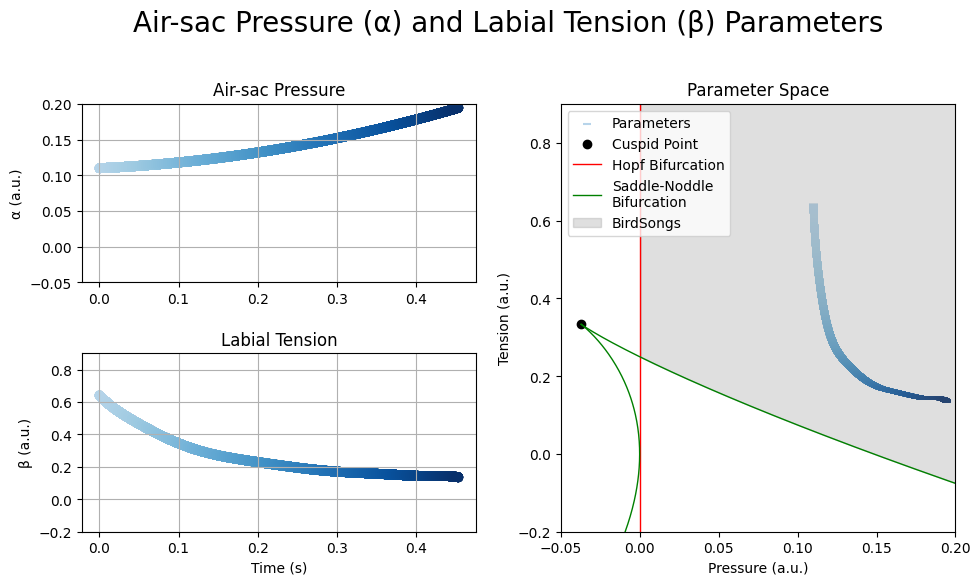

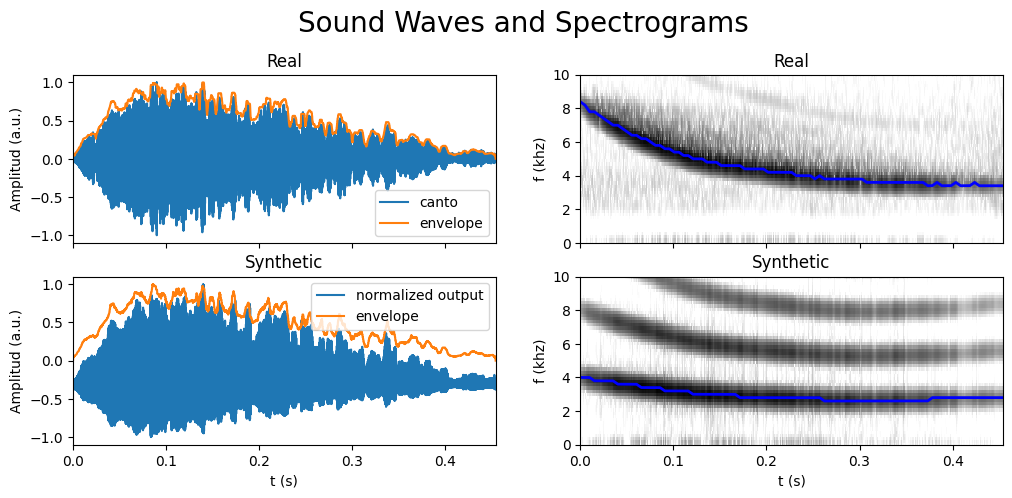

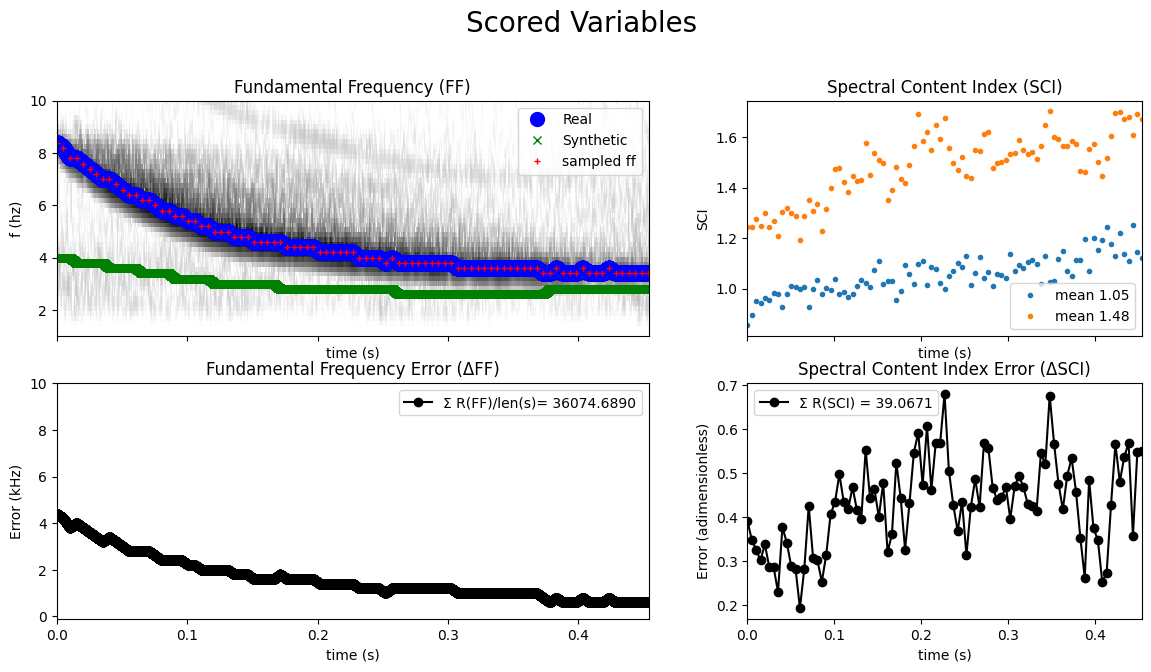

In [22]:
parametros = dict([('a0', 0.11),  ('a1', 5e-2),  ('a2', 0.3), 
                   ('b0', -0.2), ('b1', -0.95), ('b2', 0), ('gamma',0.7*datos.params["gamma"].value)])

copeton.silaba.OptSCI(parametros)
copeton.silaba.PlotAlphaBeta()
copeton.silaba.PlotSynth()
copeton.silaba.Plot(0)

# Optimization Problem γ 

We are interested to solve the following optimization problem

\begin{equation}
\begin{aligned}
\underset{ \gamma \in \mathbb{R}}{\text{min}} &\qquad || SCI_{real} - SCI_{synt} ( \gamma)||  \\
    \text { subject to }  & \qquad 0.1 <  \gamma \leq 100000
\end{aligned}
\end{equation}


## Parameters Definition and Solution

In [13]:
brute = {'Ns':20} 
#DualAnnealing = {'max_nfev':200, 'maxiter': 100}

p = lmfit.Parameters()
##    add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
p.add_many(('a0', parametros["a0"], False), ('a1', parametros["a1"], False),  ('a2', parametros["a2"], False), 
           ('b0', parametros["b0"], False),  ('b1', parametros["b1"], False), ('b2', parametros["b2"], False), 
           ('gamma', parametros["gamma"], True, 0.1, 100000))
           #('gamma', parametros["gamma"], True, 0.1, 100000))

datos, t_exe = copeton.silaba.OptimizationSCI(p, method='brute', **brute)  #, max_nfev=100)
#datos, t_exe = copeton.chunck.OptimizationGammaFF(parametros, method='dual_annealing', **DualAnnealing)  #, max_nfev=100)

In [19]:
print("γ opt =  {}".format(datos.params["gamma"].value))
print("Time of execution {} minutes".format(t_exe/60))

γ opt =  36842.16842105263
Time of execution 10.82402796347936 minutes


## Results Optimal γ, i-th Chunck

In [ ]:
#parametros

In [ ]:
p = lmfit.Parameters()
##    add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
p.add_many(('a0', parametros["a0"], False), ('a1', parametros["a1"], False),  ('a2', parametros["a2"], False), 
           ('b0', 0.01, True,-0.2,0.2),  ('b1', parametros["b1"], False), ('b2', parametros["b2"], False), 
           ('gamma', datos.params["gamma"].value, False))
           #('gamma', parametros["gamma"], True, 0.1, 100000))
#parametros["gamma"] = datos.params["gamma"].value
#parametros["a0"],parametros["a1"], parametros["a2"] = 0.01, 0, 0
parametros["b0"] = -0.11578947
copeton.silaba.OptSCI(parametros)
copeton.silaba.PlotAlphaBeta()
copeton.silaba.PlotSynth()
copeton.silaba.Plot(1)

In [ ]:
datos, t_exe = copeton.silaba.OptimizationFF(p, method='brute', **brute)  #, max_nfev=100)
datos

In [20]:
copeton.silaba.Audio()

## Optimization Problem All Parameters

We are interested to solve the following optimization problem

\begin{equation}
\begin{aligned}
\underset{a,b \in \mathbb{R}^2}{\text{min}} &\qquad || FF_{real} - FF_{synt} (a,b)||  \\
    \text { subject to }  & \qquad -1 <  a_i \leq 1\\
    \qquad \qquad \; \;   & \qquad -1 <  b_i \leq 1, \qquad \text{for }  i=1,2
\end{aligned}
\end{equation}

where

\begin{gather}
\alpha(t) = a_0 + a_1 t, \qquad  \beta(t)=b_0 + b_1 t\\
\alpha(t) = \vec{a} \cdot \vec{\tau}, \qquad \beta(t) =  \vec{b} \cdot \vec{\tau}
\end{gather}
with $\vec{\tau}=(1,t,t^2)$, $\vec{a} = (a_0, a_1, a_2)$. and $\vec{b}=(b_0, b_1, b_2)$. Since we are looking for lines in the parameter space the parameters $a_2=b_2=0$. 

In [ ]:
brute = {'Ns':8}
# DualAnnealing = {'max_nfev':1000, 'maxiter': 1000}

p = lmfit.Parameters()
# # add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
p.add_many(('a0', parametros["a0"], True, -1, 2), ('a1', parametros["a1"], True, -.1, 1), ('a2', parametros["a2"], False), 
           ('b0', parametros["b0"], True, -2, 2), ('b1', parametros["b1"], True, -1, 1), ('b2', parametros["b2"], False), 
           ('gamma', datos.params["gamma"].value, False))


datos1, t_exe1 = copeton.chunck.OptimizationFF(p, method='brute', **brute)  #, max_nfev=100)

print("Time of execution {} minutes".format(t_exe1/60))

In [ ]:
datos1

In [ ]:
datos1

In [ ]:
parametros["gamma"] = datos.params["gamma"].value
copeton.chunck.OptSCI(parametros)
copeton.chunck.PlotAlphaBeta()
copeton.chunck.PlotSynth()
copeton.chunck.Plot(1)

# Auxiliar Functions

## Video
- Create a function to make video

```` 
import os
os.system("ffmpeg -f image2 -r 1/5 -i ./images/swissGenevaLake%01d.jpg -vcodec mpeg4 -y ./videos/swissGenevaLake.mp4")
````

- Add audio to the video

````
ffmpeg -i yourvideo.avi -i sound.mp3 -c copy -map 0:v:0 -map 1:a:0 output.avi
````